# Ab-initio synthesis of amino acids

The Urey-Miller experiment, demonstrated for the first time, the prebiotic synthesis of amino acids. Although this result has been reproduced multiple times experimentally, there have been very few in-silico attempts of the same.  

Our study explores the role of standard Gibbs free energy change as a key parameter in the in-silico synthesis of Glycine in a Miller-like experiment. A network theoretic approach is used to model the experiment and simulated annealing is used to scan the reaction space.  

This file contains the following functions:
- `form_bonds`
and the code for Strecker's amino acid synthesis.

The following function are available in `main.ipynb`
- `get_number_bonds`
- `get_neutral_compound`
- `generate_random_graphs`
- `rearrange_connected_components`
- `simulated_annealing`
- `plot_fig`
- `fix_valencies`
- `input_G`

In [1]:
# Import all essential libraries

import os
import csv
import math
import warnings
import random
import numpy as np
import networkx as nx
import scipy.constants as sc
import matplotlib.pyplot as plt
import networkx.algorithms.isomorphism as iso
# %matplotlib qt
from IPython.core.debugger import Pdb
ipdb = Pdb()

The `plot_fig` function is used for plotting the network. The following color code has been used in the network:
   - Grey: Carbon
   - Green: Hydrogen
   - Blue: Nitrogen
   - Red: Oxygen  
   
Input: Graph  to be plotted

In [2]:
def plot_fig(G, title=""):
    A = nx.adjacency_matrix(G)
    pos = nx.spring_layout(G)
    nodes = list(nx.nodes(G))
    mapping = {}
    for i,j in enumerate(nodes):
        mapping[j] = i
        
    plt.figure()
    if title: plt.title(title)
    for i in G.edges():
        G[i[0]][i[1]][0]['number'] = A[mapping[i[0]], mapping[i[1]]]
    labels = nx.get_edge_attributes(G, 'number')
    edge_labels = {}
    node_colors = []
    for i in nx.nodes(G):
        if i._element=="H":
            node_colors.append('#ccffd3')
        elif i._element=="C":
            node_colors.append('grey')
        elif i._element=="O":
            node_colors.append('red')
        elif i._element=="N":
            node_colors.append('#74b6fc')
            
            
    for i in labels:
        edge_labels[(i[0], i[1])] = labels[i]
    nx.draw(G, pos, with_labels=True,edge_color='black',width=1,linewidths=1,node_size = 500,node_color=node_colors,alpha=0.9)
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)
    plt.show()

Definition of the Atom class. The objects of this Class are used as nodes in our network.
Attributes in the Class:
  - `_number`: number tag
  - `_element`: element
  - `_valency`: valency
  - `_name`: element + number tag  
  
Member functions in the Class:
  - `get_max_valency`: returns the maximum valency of that element
  - `current_valency`: updates the valency of an Atom object. Takes a Graph as an input
  - `get_free_valency`: returns the number of free electrons of a node. Takes a graph as an input

In [3]:
class Atom():
    def __init__(self, name, number):
        self._name = name + " " + str(number)
        self._number = number
        self._element = name
        self._valency = self.get_max_valency()

    def get_max_valency(self):
        name = self._element[0]
        if name == "H":
            return 1
        elif name == "C":
            return 4
        elif name == "N":
            return 3
        elif name == "O":
            return 2
        elif name == "S":
            return 2

    def current_valency(self, G):
        neig = nx.degree(G, self)
        max_val = self.get_max_valency()
        if neig > max_val:
            ipdb.set_trace()
            raise ValueError('Atom has more neighbours than valence')
        else:
            # print(max_val, neig)
            self._valency = max_val - neig
        
    def get_total_valency(self, G):
        neig = nx.degree(G, self)
        free_electrons = self.get_max_valency() - neig
        return free_electrons
        
        
    def __repr__(self):
        return self._name

The `fix_valencies` function is used to update the valencies of the atoms. This updates the atom's valency based on the number of edges that atom forms.  
Input:
- `G`: Network in which the valencies should be updated

In [4]:
def fix_valencies(G):
    for node in nx.nodes(G):
        degree = len(G[node])
        if degree > 0:
            node.current_valency(G)

Creating the `H` graph to be used for `input_G` isomorphism
The `data_G` dictionary links these components to their corresponding free energy values

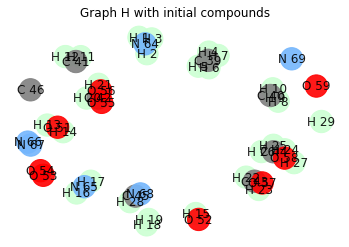

In [5]:
H = nx.MultiGraph()

H_lists = [Atom("H",i) for i in range(1,30)]
C_lists = [Atom("C",i) for i in range(39, 47)]
O_lists = [Atom("O",i) for i in range(51, 60)]
N_lists = [Atom("N",i) for i in range(64, 70)]
for i,lst in enumerate([H_lists, C_lists, O_lists, N_lists]):
    for comp in lst:
        H.add_node(comp, data=comp)

H.add_edges_from([(H_lists[0], N_lists[0]), (N_lists[0], H_lists[1]), (N_lists[0], H_lists[2])])
H.add_edges_from([(H_lists[3], C_lists[0]), (H_lists[4], C_lists[0]), (H_lists[5], C_lists[0]), (H_lists[6], C_lists[0])])
H.add_edges_from([(H_lists[7], C_lists[1]), (H_lists[8], C_lists[1]), (H_lists[9], C_lists[1])])
H.add_edges_from([(H_lists[10], C_lists[2]), (H_lists[11], C_lists[2])])
H.add_edges_from([(H_lists[12], O_lists[0]), (H_lists[13], O_lists[0])])
H.add_edges_from([(H_lists[14], O_lists[1])])
H.add_edges_from([(H_lists[15], N_lists[1]), (N_lists[1], H_lists[16])])
H.add_edges_from([(H_lists[17], H_lists[18])])
H.add_edges_from([(O_lists[2], O_lists[3])])
H.add_edges_from([(N_lists[2], N_lists[3]), (N_lists[2], N_lists[3]), (N_lists[2], N_lists[3])])
H.add_edges_from([(H_lists[19], C_lists[3]),(O_lists[4], C_lists[3]),(O_lists[4], C_lists[3]),(O_lists[5], C_lists[3]),(H_lists[20], O_lists[5])])
H.add_edges_from([(H_lists[21], C_lists[4]),(O_lists[6], C_lists[4]),(O_lists[6], C_lists[4]),(H_lists[22], C_lists[4])])
H.add_edges_from([(H_lists[23], C_lists[5]), (H_lists[24], C_lists[5]), (H_lists[25], C_lists[5]),(O_lists[7], C_lists[5]),(O_lists[7], H_lists[26])])
H.add_edges_from([(H_lists[27], C_lists[6]), (N_lists[4], C_lists[6]), (N_lists[4], C_lists[6]), (N_lists[4], C_lists[6])])

plot_fig(H, "Graph H with initial compounds")

data_G = {}
G_value = [-185.9402151,-213.1921923,2.651927862,247.7699191,-380.6041595,-97.3578968,43.5280415,-97.16928744,-563.5848,-269.5222798,-379.0914382,-16.77210243,133.6241442,736.5926058,-149.516614,132.4236,-139.8716185,361.0634601]

entities = nx.connected_components(H)
entities = list(entities)
for i in range(len(entities)):
#     print(i)
    sub = H.subgraph(list(entities[i]))
    data_G[sub] = G_value[i]
#     plot_fig(sub, G_value[i])
fix_valencies(H)

#A is CH2O and B is NH3
A = H.subgraph(list(entities[9]))
B = H.subgraph(list(entities[0]))

Finding $\Delta G^{\circ}$ of all the connected components in a network
Input: 
- G: the Graph network for which G should be calculated
Output: 
- Sum total Gibbs free energy for the whole Graph

In [6]:
def input_G(G):
    cc = list(nx.connected_components(G))
    G_energy = 0
    
    for i in range(len(cc)):
        found = 0
        
        sub_G = G.subgraph(list(cc[i]))
        same = False
        
        for j in data_G:
            GH = iso.GraphMatcher(sub_G,j)
            if GH.is_isomorphic() == True:
                same = True
            else:
                same = False
            
            if same == True:
                if len(GH.mapping) != 2:
                    for k in GH.mapping:
                        if str(k)[0] == str(GH.mapping[k])[0]:
                            same = True
                        else:
                            same = False
                            break
                else:
                    keys = []
                    values = []
                    for i in GH.mapping.keys():
                        keys.append(str(i).split()[0])
                    for i in GH.mapping.keys():
                        values.append(str(i).split()[0])
                    keys = keys.sort()
                    values = values.sort()
                    if keys == values:
                        same = True
                    else: 
                        same = False
                        
            if same == True:
                found = 1
                break

        if same == True:
            G_energy += data_G[j]
            
        elif same == False:
            randomp = G.subgraph(list(cc[i]))
            plot_fig(randomp)
            
            val = float(input('Enter G value of %s: '%list(cc[i])))
            data_G[sub_G] = val
            G_energy += val
            
    return G_energy

Defining a new graph `N` in which all unique molecules of size 4 and below are stored, for further analysis

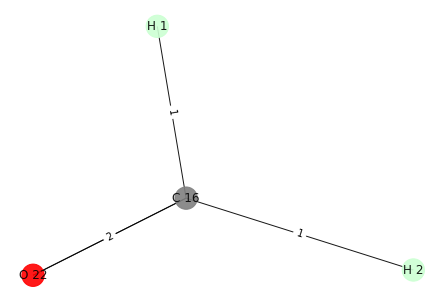

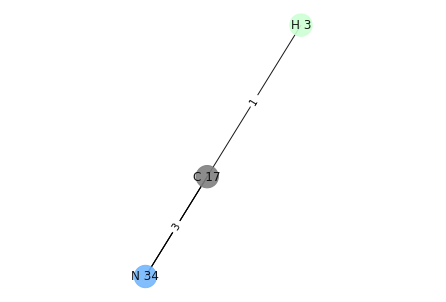

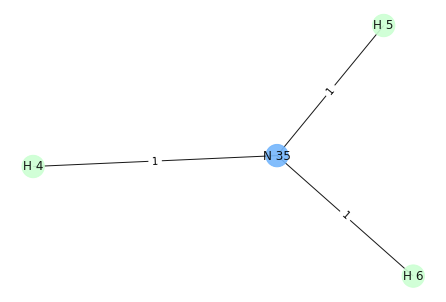

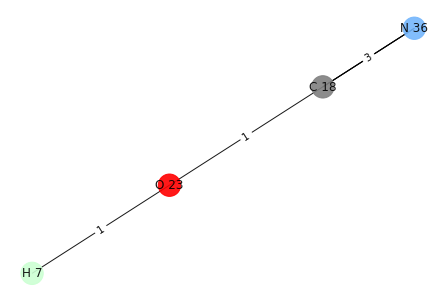

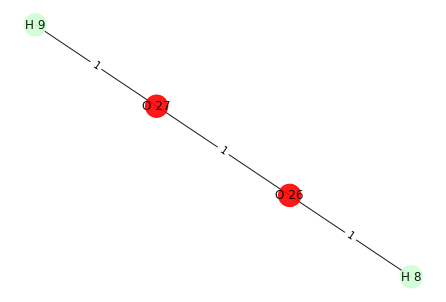

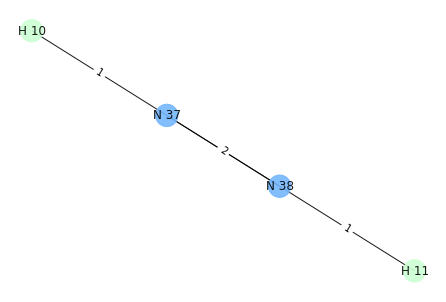

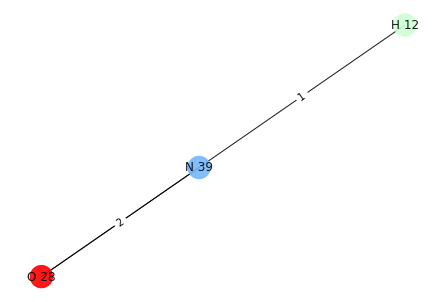

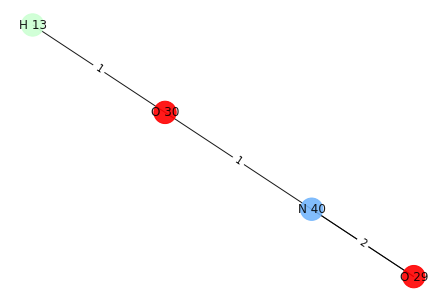

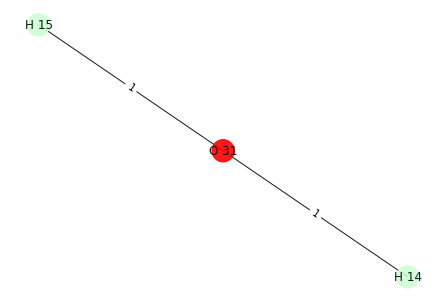

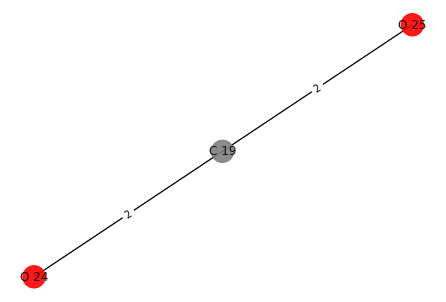

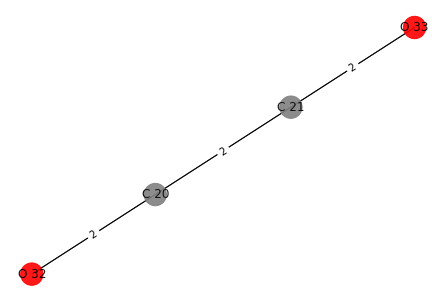

In [7]:
#Compounds of size = 3/4

N = nx.MultiGraph()

H_list_n = [Atom("H",i) for i in range(1,16)]
C_list_n = [Atom("C",i) for i in range(16, 22)]
O_list_n = [Atom("O",i) for i in range(22, 34)]
N_list_n = [Atom("N",i) for i in range(34, 41)]
for i,lst in enumerate([H_list_n, C_list_n, O_list_n, N_list_n]):
    for comp in lst:
        N.add_node(comp, data=comp)
#CH2O        
N.add_edges_from([(H_list_n[0], C_list_n[0]), (H_list_n[1], C_list_n[0]), (O_list_n[0], C_list_n[0]), (O_list_n[0], C_list_n[0])])
#HCN
N.add_edges_from([(C_list_n[1], H_list_n[2]), (C_list_n[1], N_list_n[0]), (C_list_n[1], N_list_n[0]), (C_list_n[1], N_list_n[0])])
#NH3
N.add_edges_from([(H_list_n[3], N_list_n[1]), (N_list_n[1], H_list_n[4]), (N_list_n[1], H_list_n[5])])
#CNOH
N.add_edges_from([(C_list_n[2], N_list_n[2]), (C_list_n[2], N_list_n[2]), (C_list_n[2], N_list_n[2]), (C_list_n[2], O_list_n[1]), (O_list_n[1], H_list_n[6])])
#CO2
N.add_edges_from([(O_list_n[2], C_list_n[3]), (O_list_n[2], C_list_n[3]), (O_list_n[3], C_list_n[3]), (O_list_n[3], C_list_n[3])])
#H2O2
N.add_edges_from([(O_list_n[4], H_list_n[7]), (O_list_n[4], O_list_n[5]), (O_list_n[5], H_list_n[8])])
#N2H2
N.add_edges_from([(H_list_n[9], N_list_n[3]), (N_list_n[3], N_list_n[4]), (N_list_n[3], N_list_n[4]), (H_list_n[10], N_list_n[4])])
#HNO
N.add_edges_from([(H_list_n[11], N_list_n[5]), (O_list_n[6], N_list_n[5]), (O_list_n[6], N_list_n[5])])
#HNO2
N.add_edges_from([(O_list_n[7], N_list_n[6]), (O_list_n[7], N_list_n[6]), (O_list_n[8], N_list_n[6]), (O_list_n[8], H_list_n[12])])
#H2O
N.add_edges_from([(H_list_n[13], O_list_n[9]), (H_list_n[14], O_list_n[9])])
#C2O2
N.add_edges_from([(O_list_n[10], C_list_n[4]), (O_list_n[10], C_list_n[4]), (C_list_n[4], C_list_n[5]), (C_list_n[5], C_list_n[4]), (O_list_n[11], C_list_n[5]), (O_list_n[11], C_list_n[5])])

fix_valencies(N)
for i in nx.connected_components(N):
    plot_fig(N.subgraph(list(i)))

The `form_bonds` function does the following:
- A pair of connected components are selected from the graph sequentially.
- All the hydrogen atoms in both the connected components are identified. And if any of the components don't have hydrogen atoms, it was prevented from being iterated again.
- If the connected component has more than one hydrogen atom, the subsequent reactions was carried out sequentially for all the hydrogen atoms. The hydrogen atoms picked from the two connected components are named `hydro1` and `hydro2`.
- The neighbor of the hydrogen atoms `hydro1` and `hydro2`, from the connected components, is identified and named `neigh1` and `neighr2`.
- The bonds between (neighbor1, hydro1) and (neighbor2, hydro2) are broken and bonds between (neighbor1, neighbor2) are created.
- Atoms that have neighbors that are not exclusively hydrogen atoms are identified. If the number of atoms having a non hydrogen neighbor is greater than one, then the entire list is looped over sequentially to obtain all possible combinations. The atom picked is named `non_h_neighbor`.
- Edges between the `hydro1` atom `non_h_neighbor` are added in the graph and an edge between `non_h_neighbor` and one of its initial neighbors (`init_neigh`) is removed from the graph to satisfy the valency conditions. A bond between `init_neigh` and `hydro2` is added to the network.
- All new compounds are added to a dictionary as the key and the standard Gibbs free energy value is taken as the value.

In [8]:
def form_bonds(G_param, order):
    M = G_param.copy()
    M_dict = {}
    max_size = 11
    connected_components = list(nx.connected_components(M))
    if order == []:
        random.shuffle(connected_components)
    n = len(connected_components)
    
    while n >= 2:
        if (len(connected_components[0]) + len(connected_components[1])) > max_size:
            if len(connected_components[0]) >= len(connected_components[1]):
                connected_components = connected_components[1:]
            else:
                connected_components.pop(1)
        else:
            mol1 = M.subgraph(list(connected_components[0]))
            mol2 = M.subgraph(list(connected_components[1]))

            plot_fig(mol1)
            plot_fig(mol2)

            H_list1 = [i for i in nx.nodes(mol1) if i._element == "H"]
            H_list2 = [i for i in nx.nodes(mol2) if i._element == "H"]

            flag = 1
            flag1 = 1
            flag2 = 1
            if len(H_list1) > 1:
                H_to_be_removed1 = H_list1[random.randint(0, len(H_list1)-1)]
            elif len(H_list1) == 1:
                H_to_be_removed1 = H_list1[0]
            else:
                flag1 = 0

            if len(H_list2) > 1:
                H_to_be_removed2 = H_list2[random.randint(0, len(H_list2)-1)]
            elif len(H_list2) == 1:
                H_to_be_removed2 = H_list2[0]
            else:
                flag2 = 0

            flag = flag1*flag2
            if flag:
                neigh1 = [i for i in mol1[H_to_be_removed1]][0]
                neigh2 = [i for i in mol2[H_to_be_removed2]][0]

                M.remove_edge(H_to_be_removed1, neigh1)
                M.remove_edge(H_to_be_removed2, neigh2)
                M.add_edge(neigh1, neigh2)

                fix_valencies(M)
                plot_fig(M.subgraph(list(nx.node_connected_component(M, neigh1))))
                non_H_nodes = []
                for i in nx.node_connected_component(M, neigh1):
                    if (i._name.split()[0]!="H"):
                        non_H_nodes.append(i)
                non_H_nodes = list(set(non_H_nodes))

                for i in range(len(non_H_nodes)):
                    M_new = M.subgraph(list(nx.node_connected_component(M, neigh1))).copy()
                    temp1 = list(M_new[non_H_nodes[i]].keys())
                    temp1 = [i for i in temp1 if i._element !="H"][0]
                    print("Removing edge between:", non_H_nodes[i], temp1)
                    M_new.remove_edge(non_H_nodes[i], temp1)
                    print("Adding edge between:", non_H_nodes[i], H_to_be_removed1)
                    M_new.add_edge(H_to_be_removed1, non_H_nodes[i])
                    fix_valencies(M_new)

                    plot_fig(M_new.subgraph(nx.node_connected_component(M_new, neigh1)))
                    
                    second_node = [j for j in non_H_nodes if j._valency!=0]
                    M_new.add_edge(H_to_be_removed2, second_node[0])
                    fix_valencies(M_new)
                    plot_fig(M_new.subgraph(nx.node_connected_component(M_new, H_to_be_removed2)))

                    M_dict[M_new.subgraph(nx.node_connected_component(M_new, neigh1))] = input_G(M_new.subgraph(nx.node_connected_component(M_new, neigh1)))

                connected_components = connected_components[2:]
                n = len(connected_components)
            else:
                connected_components = connected_components[1:]
                n = len(connected_components)

    return M_dict

The following code was run for `trails=10` in our project.  
Here, a sample run for `trails=1` is shown.

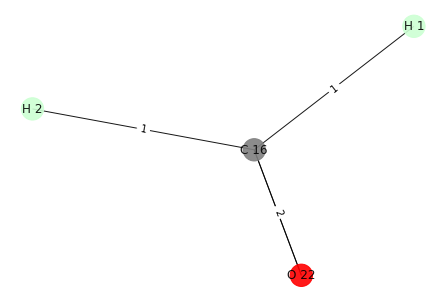

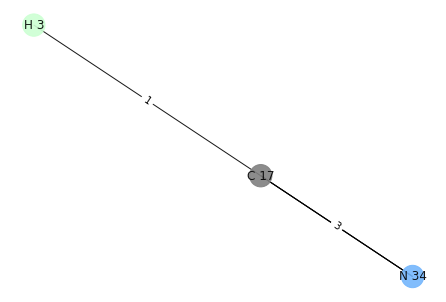

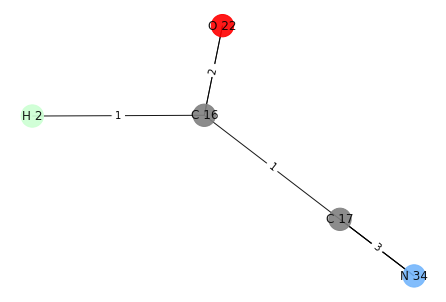

Removing edge between: N 34 C 17
Adding edge between: N 34 H 1


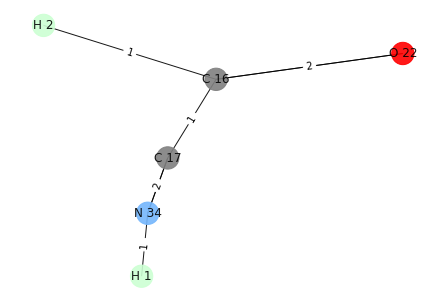

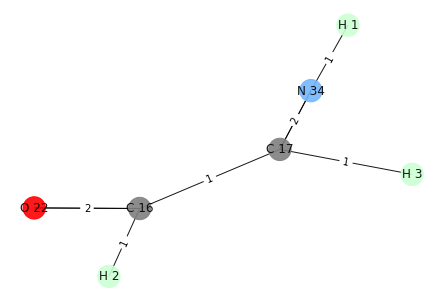

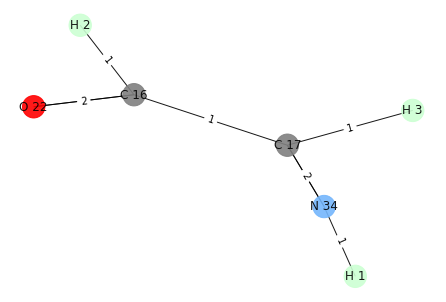

Enter G value of [H 2, C 17, H 3, H 1, C 16, N 34, O 22]: -7.380497132
Removing edge between: O 22 C 16
Adding edge between: O 22 H 1


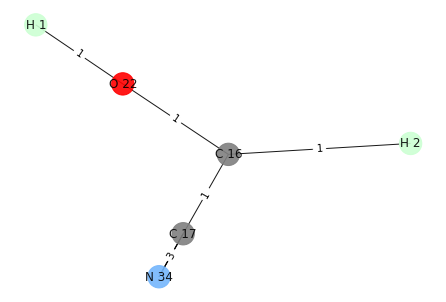

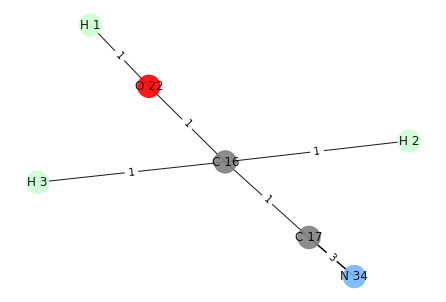

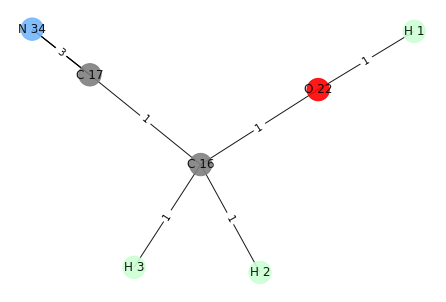

Enter G value of [H 2, H 3, C 17, H 1, C 16, N 34, O 22]: -261.5047571
Removing edge between: C 17 N 34
Adding edge between: C 17 H 1


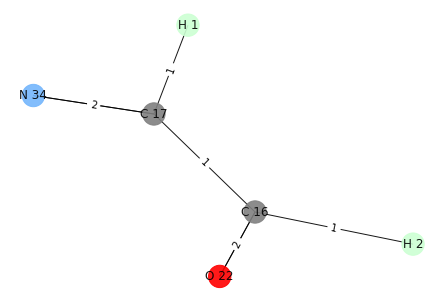

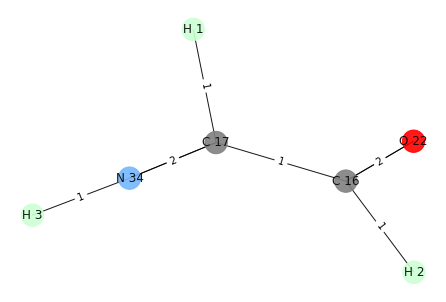

Removing edge between: C 16 C 17
Adding edge between: C 16 H 1


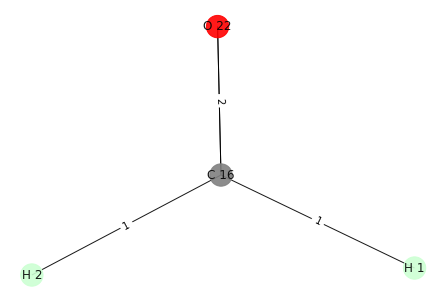

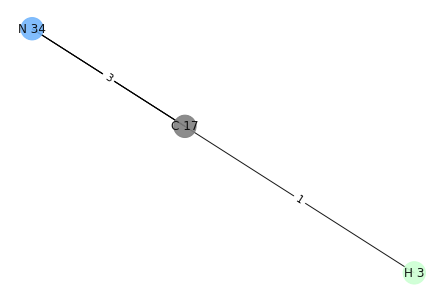

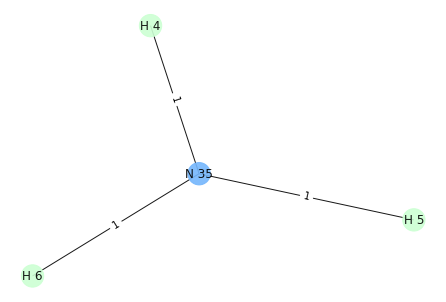

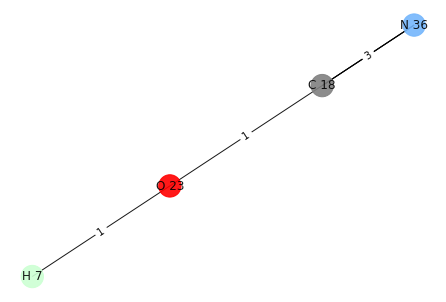

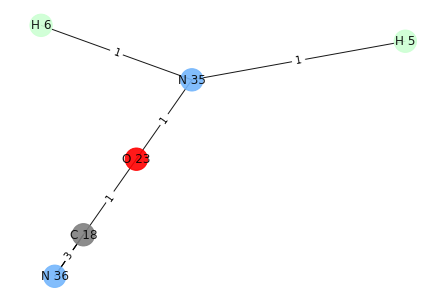

Removing edge between: N 36 C 18
Adding edge between: N 36 H 4


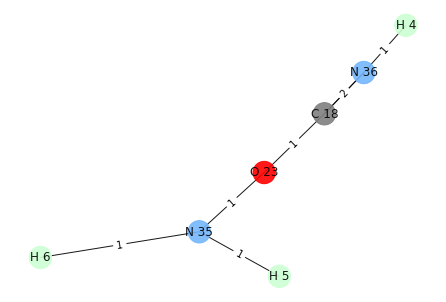

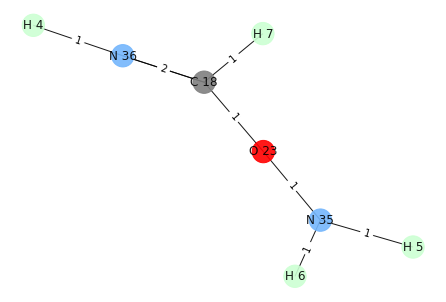

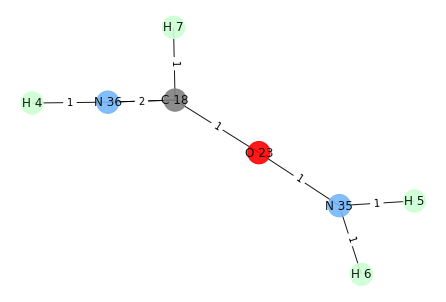

Enter G value of [O 23, H 7, C 18, N 35, H 4, N 36, H 5, H 6]: 100
Removing edge between: O 23 C 18
Adding edge between: O 23 H 4


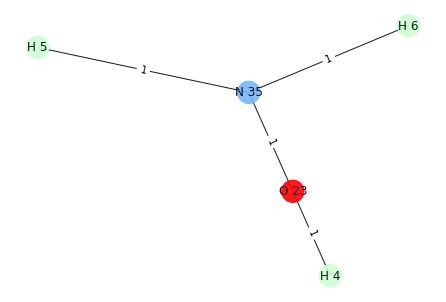

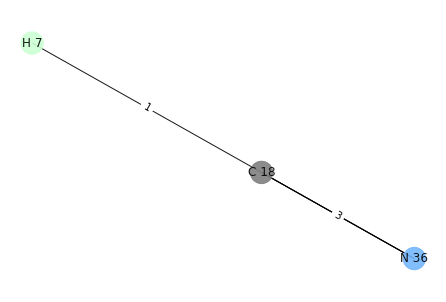

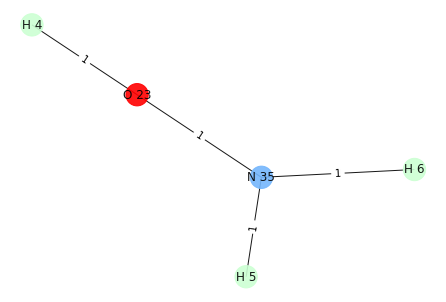

Enter G value of [O 23, N 35, H 4, H 5, H 6]: -215.860156
Removing edge between: N 35 O 23
Adding edge between: N 35 H 4


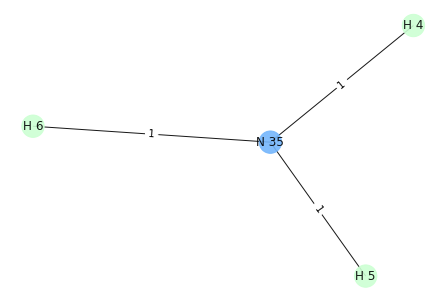

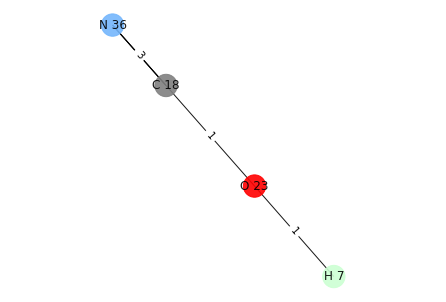

Removing edge between: C 18 O 23
Adding edge between: C 18 H 4


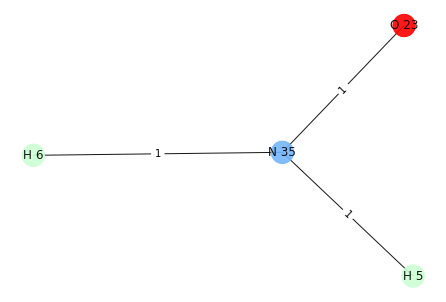

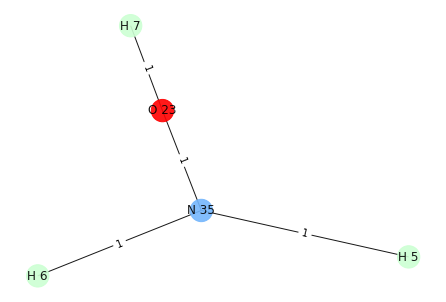

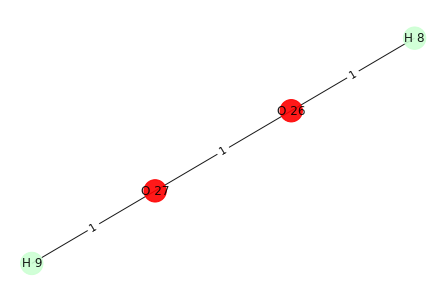

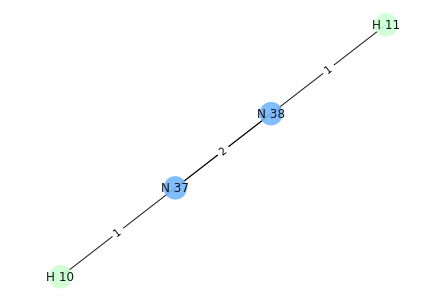

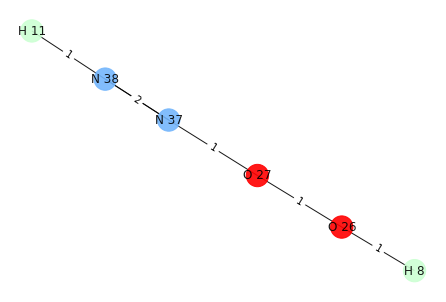

Removing edge between: O 27 O 26
Adding edge between: O 27 H 9


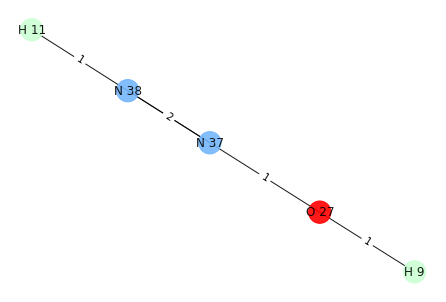

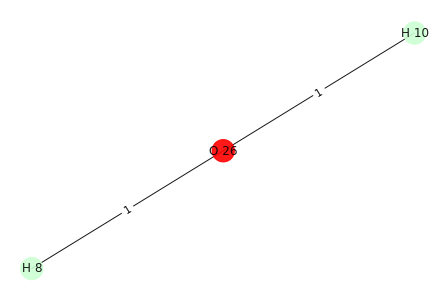

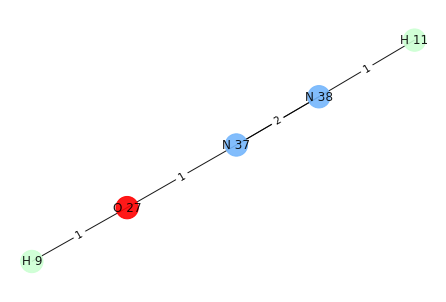

Enter G value of [O 27, H 9, N 37, H 11, N 38]: -107.61248
Removing edge between: O 26 O 27
Adding edge between: O 26 H 9


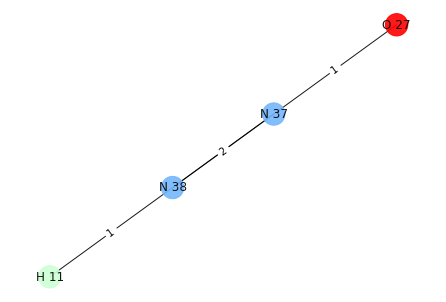

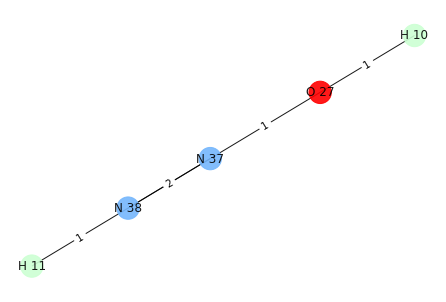

Removing edge between: N 38 N 37
Adding edge between: N 38 H 9


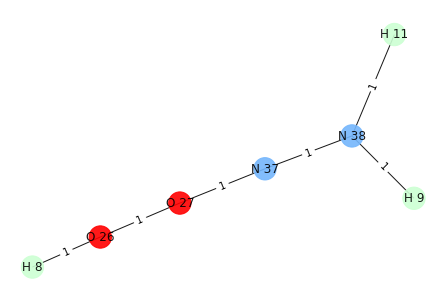

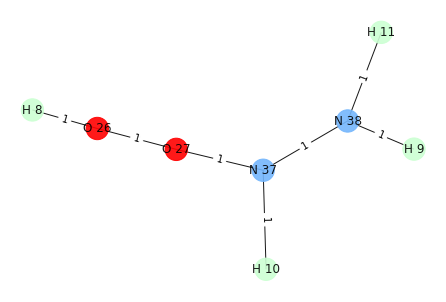

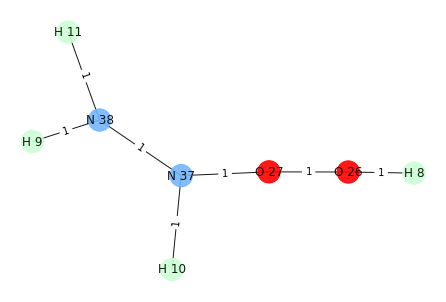

Enter G value of [H 8, H 9, H 10, O 26, N 38, N 37, H 11, O 27]: 100
Removing edge between: N 37 O 27
Adding edge between: N 37 H 9


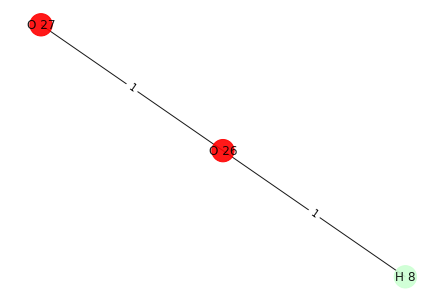

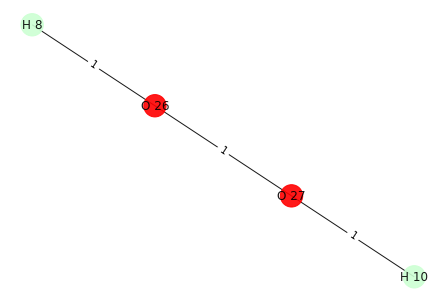

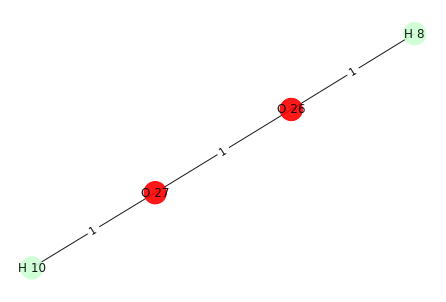

Enter G value of [H 10, O 27, O 26, H 8]: -309.1934413


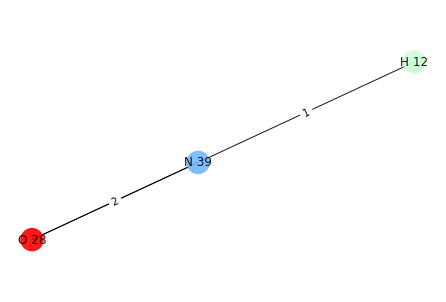

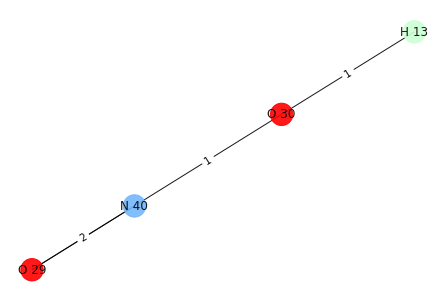

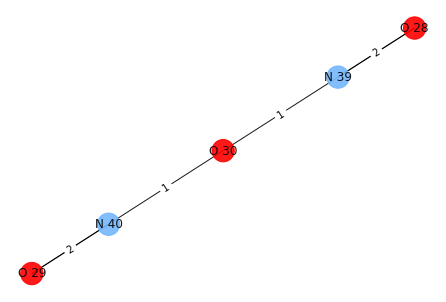

Removing edge between: O 28 N 39
Adding edge between: O 28 H 12


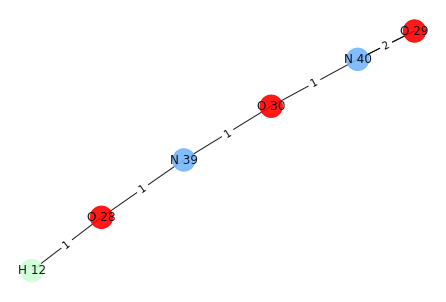

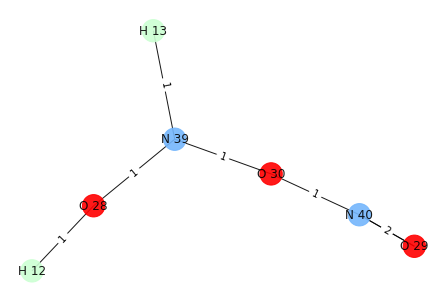

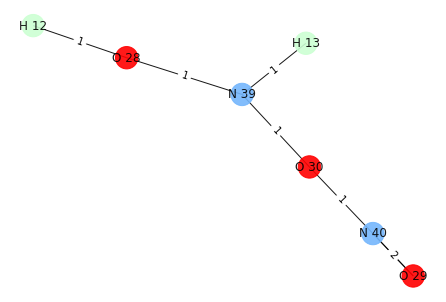

Enter G value of [O 28, N 39, O 29, H 13, O 30, N 40, H 12]: 100
Removing edge between: N 39 O 28
Adding edge between: N 39 H 12


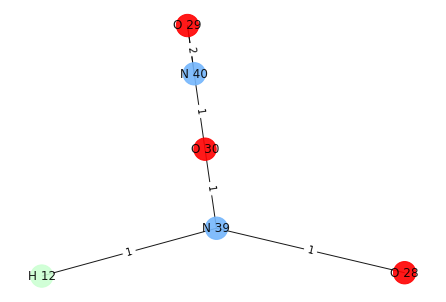

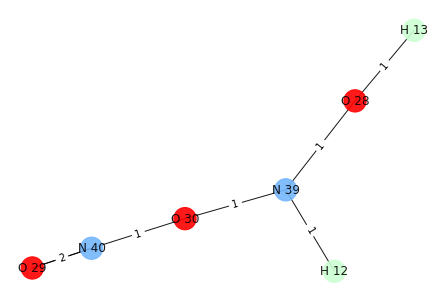

Removing edge between: O 29 N 40
Adding edge between: O 29 H 12


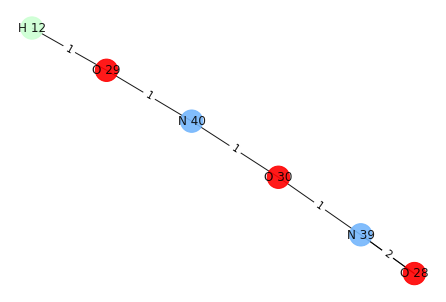

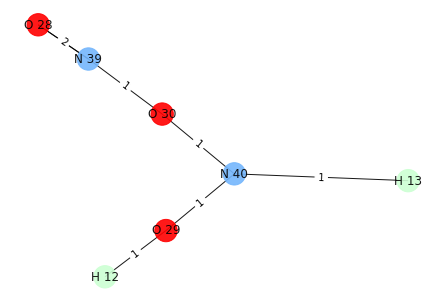

Removing edge between: N 40 O 29
Adding edge between: N 40 H 12


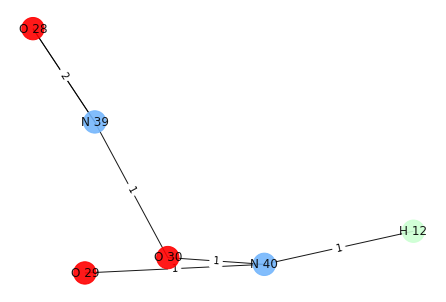

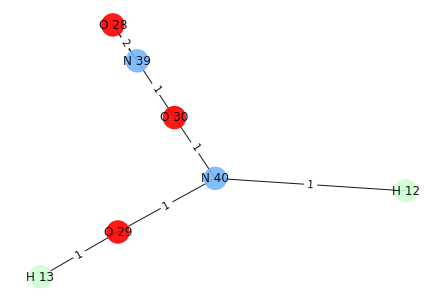

Removing edge between: O 30 N 39
Adding edge between: O 30 H 12


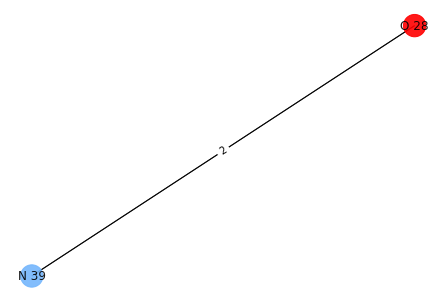

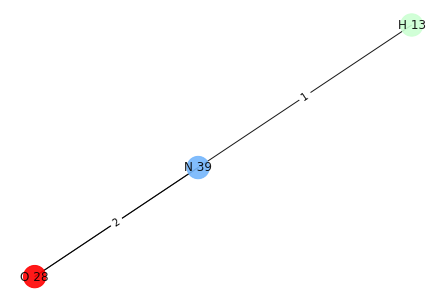

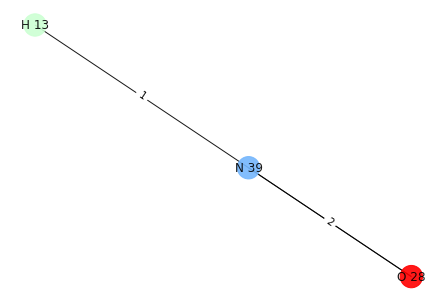

Enter G value of [H 13, O 28, N 39]: -55.40205694


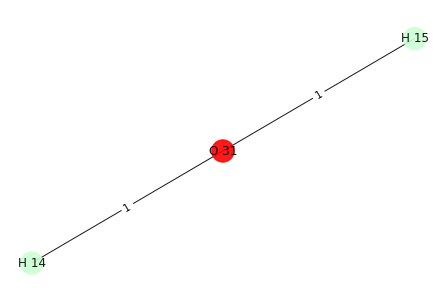

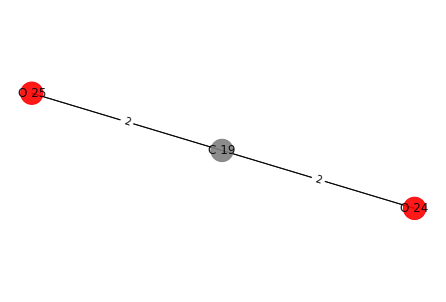

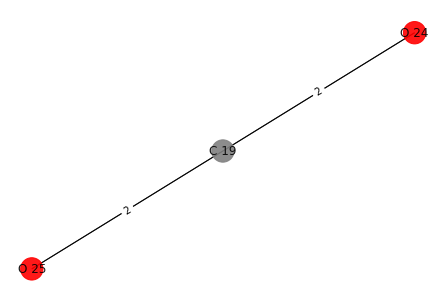

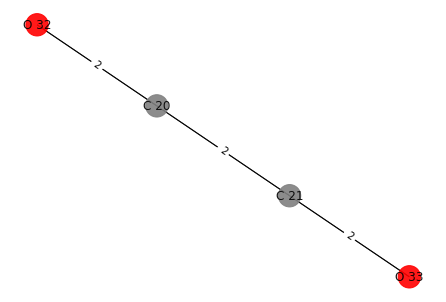

In [9]:
trails = 1
n = len(list(nx.connected_components(N)))
final_dict = {}
order = [i for i in range(n)]
for i in range(trails):
    if i == 0:
        final_dict.update(form_bonds(N, order))
    else:
        final_dict.update(form_bonds(N))

---
Consolidating the list of all compounds formed.  
All compounds that have a $\Delta G^{\circ} > 10$ are removed from the list.

In [10]:
new_final = final_dict.copy()
for i in final_dict:
    if final_dict[i] > 10:
        new_final.pop(i)
new_final_copy = new_final

Identifying all the Cyanides in the final dictionary of compounds.

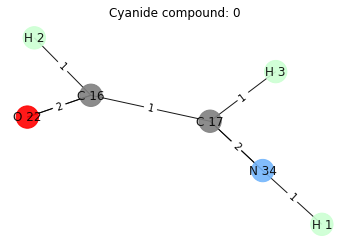

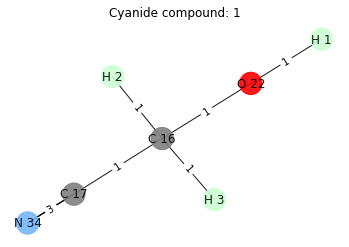

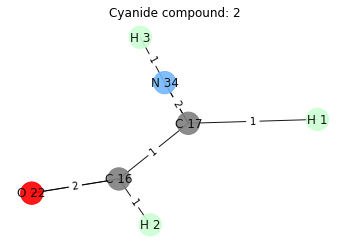

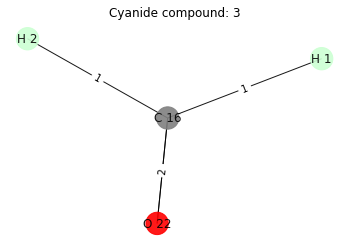

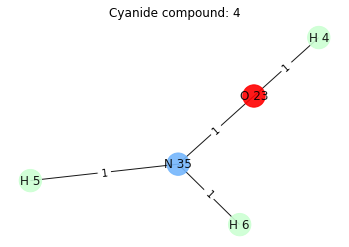

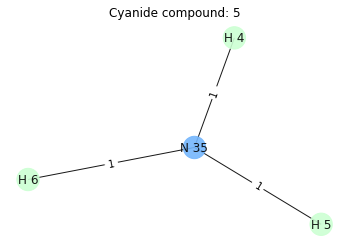

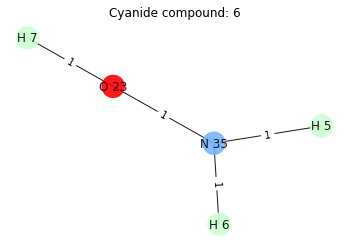

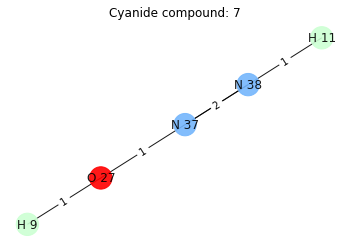

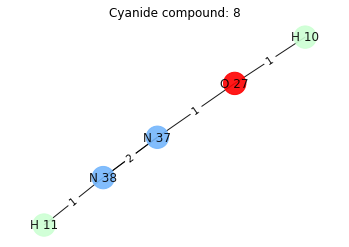

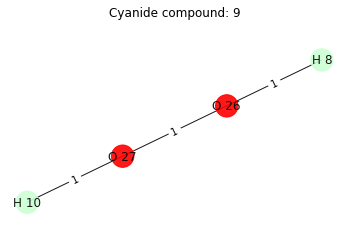

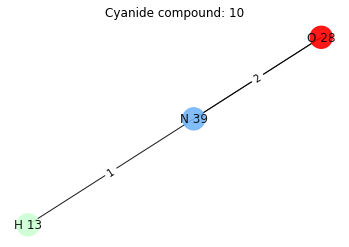

In [11]:
cyanides = {}
for compound in new_final:
    cyanides[compound] = []
    carbons = [i for i in nx.nodes(compound) if i._name.split()[0]=="C"]
    for i in carbons:
        for j in compound[i]:
            if j._element=="N" and compound[i][j][0]['number']==3:
                cyanides[compound].append((i,j))
                
for i,j in enumerate(cyanides):
    plot_fig(j, "Cyanide compound: "+str(i))

Identifying all the Aldehydes/Ketones in the final dictionary of compounds.

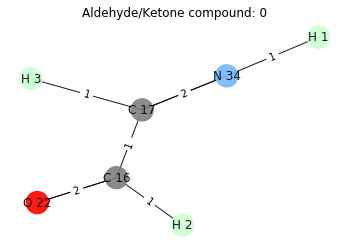

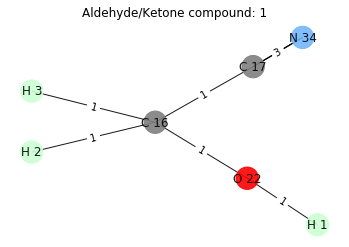

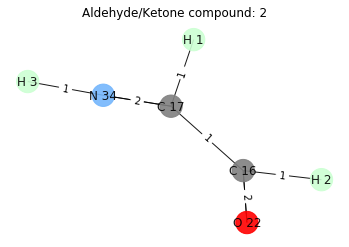

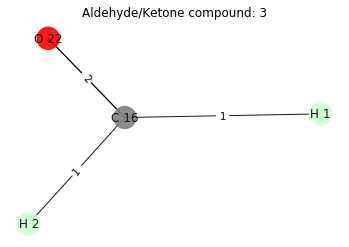

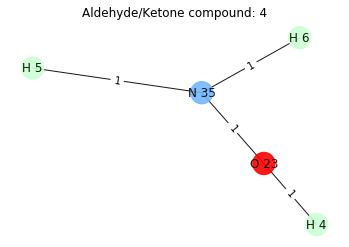

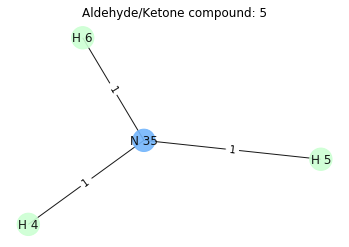

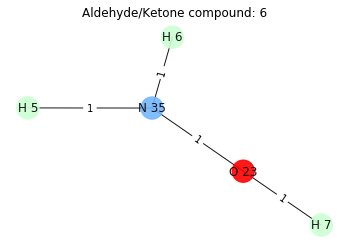

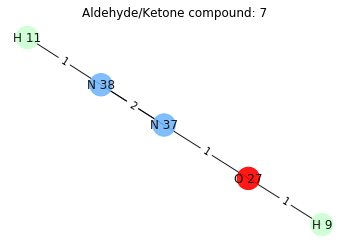

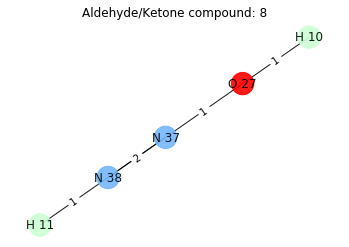

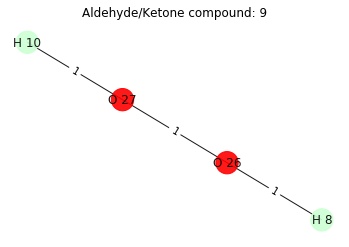

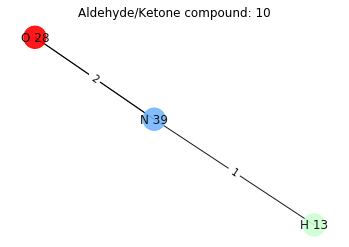

In [12]:
aldehyde_ketones = {}
for compound in new_final:
    aldehyde_ketones[compound] = []
    carbons = [i for i in nx.nodes(compound) if i._name.split()[0]=="C"]
    for i in carbons:
        flag2 = False
        flag3 = False
        neigh = ()
        for j in compound[i]:
            if j._element=="O" and compound[i][j][0]['number']==2:
                neigh = (i,j)
            if (j._element=="H") or (j._element=="C"):
                flag2 = True
            if (j._element=="O") and (compound[i][j][0]['number']==1):
                flag3 = True
        if neigh and flag2 and (not flag3):
            aldehyde_ketones[compound].append(neigh)
            
for i,j in enumerate(aldehyde_ketones):
    plot_fig(j, "Aldehyde/Ketone compound: "+str(i))

Identifying all the Amines in the final dictionary of compounds.

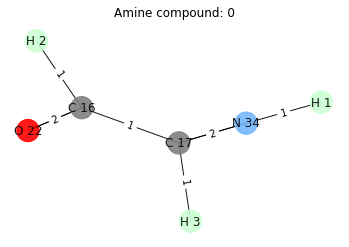

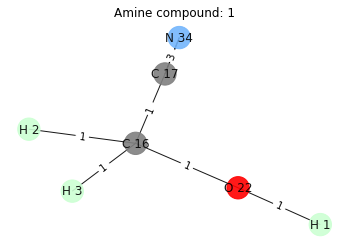

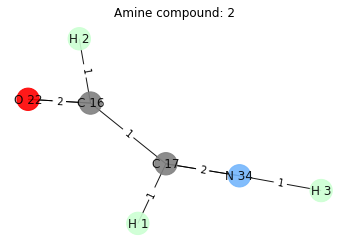

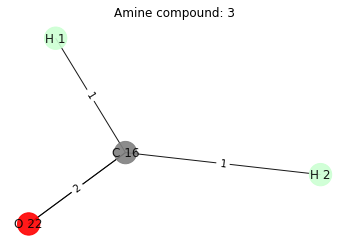

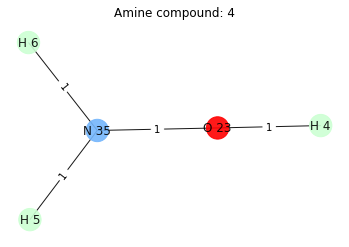

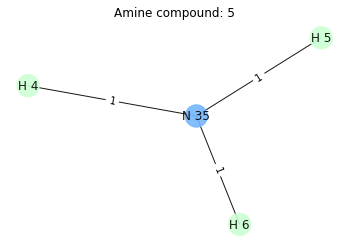

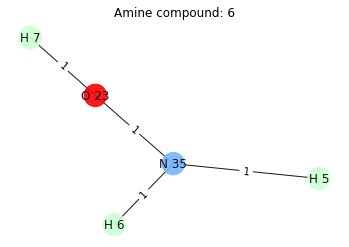

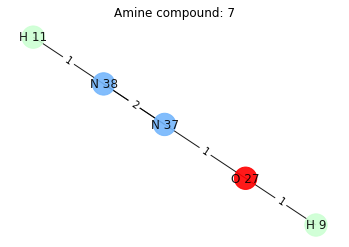

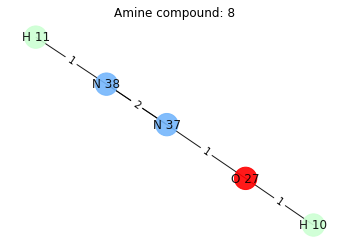

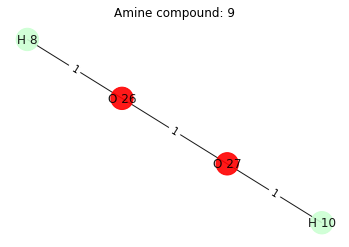

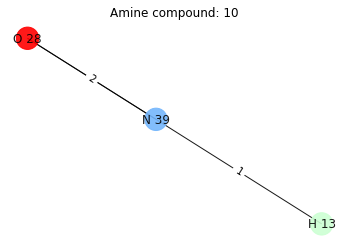

In [13]:
amine = {}
for compound in new_final:
    amine[compound] = []
    nitrogens = [i for i in nx.nodes(compound) if i._element=="N"]
    for i in nitrogens:
        count = 0
        for j in compound[i]:
            if j._element == "H":
                count += 1
        if count>=2:
            neigh = [i]
            for n in list(compound.neighbors(i)): neigh.append(n)
            neigh = tuple(neigh)
            amine[compound].append(neigh)
            
for i,j in enumerate(amine):
    plot_fig(j, "Amine compound: "+str(i))

Code to perform Strecker amino acid synthesis.  
Additional hydrogen, carbon, oxygen and nitrogen atoms are added for this simulation.

Next compound


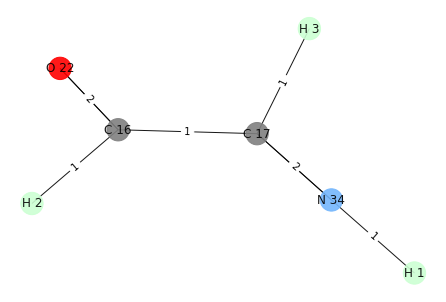

Aldehyde or Ketone


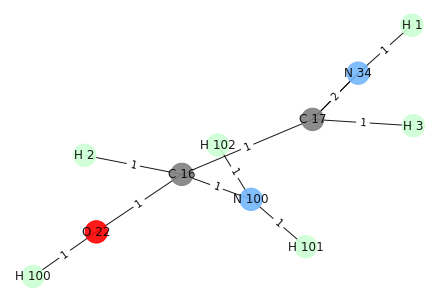

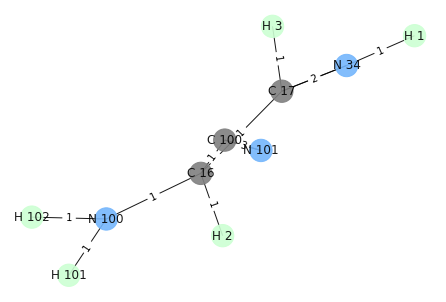

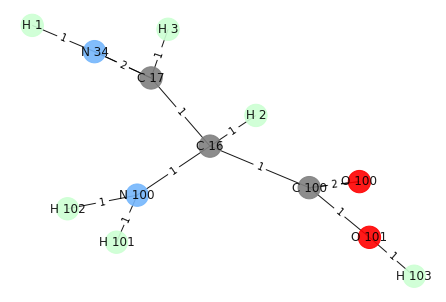

Enter G value of [H 2, O 101, H 102, H 3, C 100, H 101, H 103, H 1, N 100, C 16, N 34, C 17, O 100]: 100


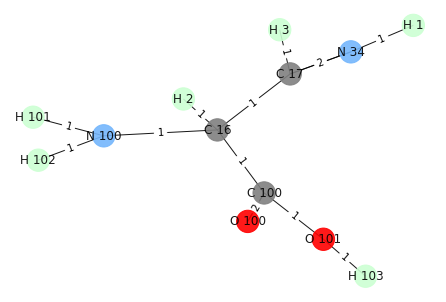

Next compound


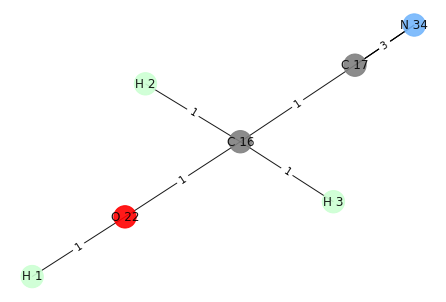

Cyanide
(C 17, N 34)


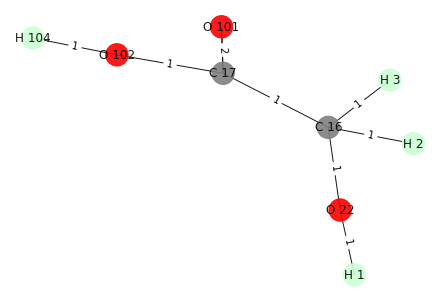

Aldehyde or Ketone


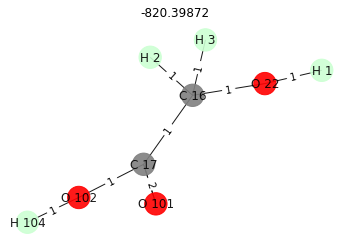

Next compound


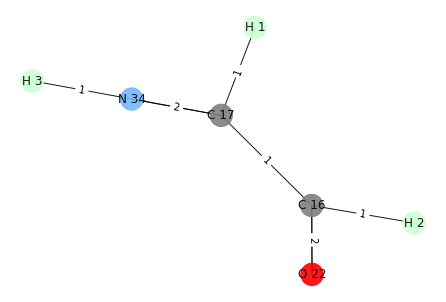

Aldehyde or Ketone


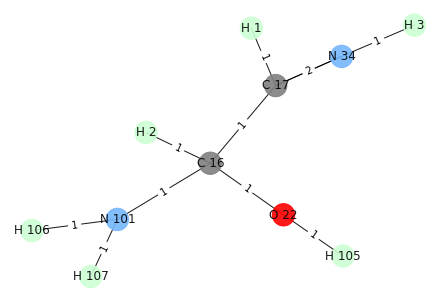

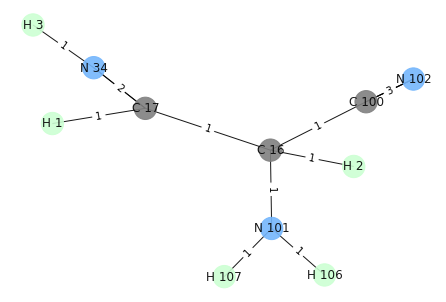

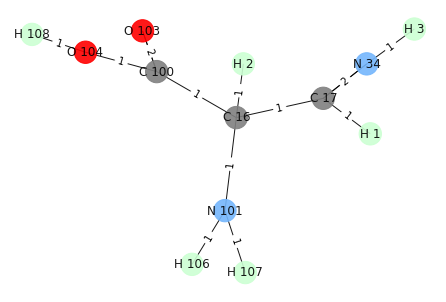

Next compound


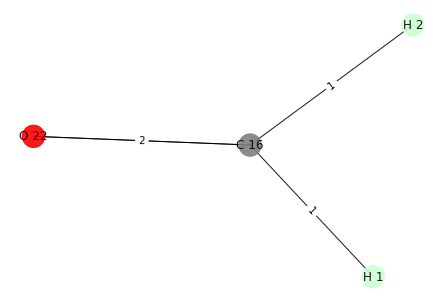

Aldehyde or Ketone


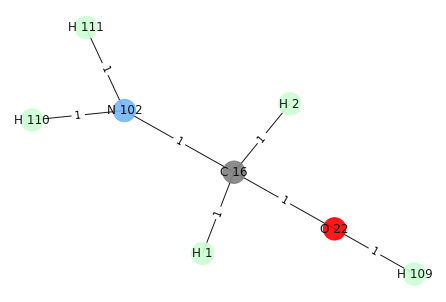

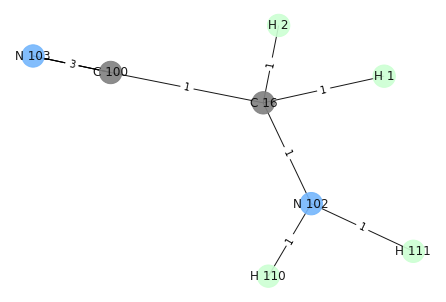

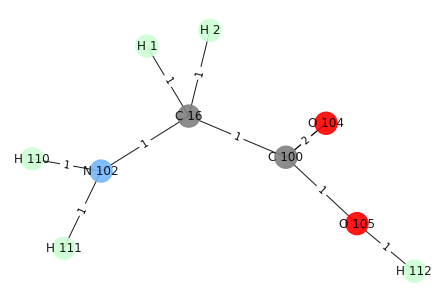

Enter G value of [H 2, O 104, H 112, C 100, H 110, H 1, N 102, C 16, H 111, O 105]: -664.5829247


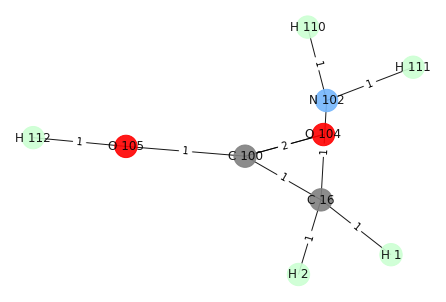

Next compound


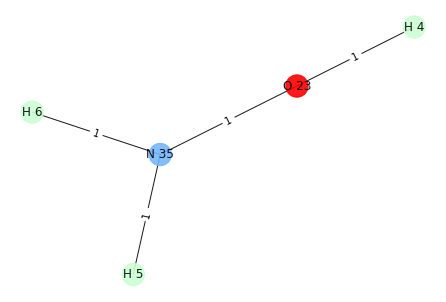

Next compound


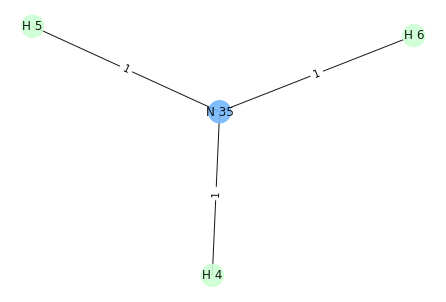

Next compound


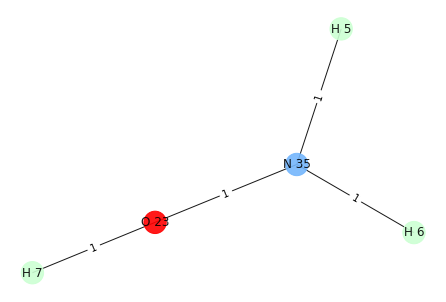

Next compound


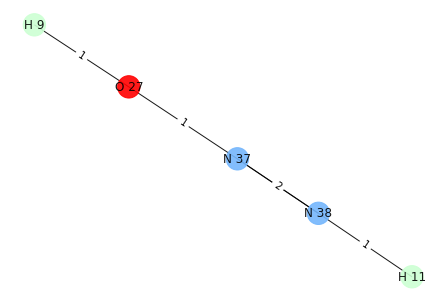

Next compound


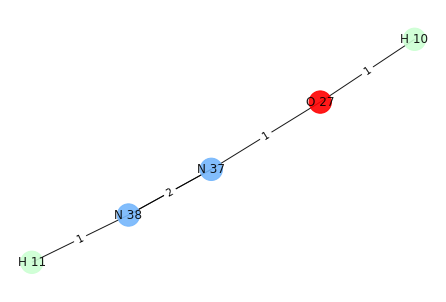

Next compound


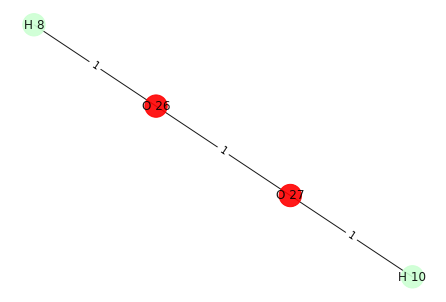

Next compound


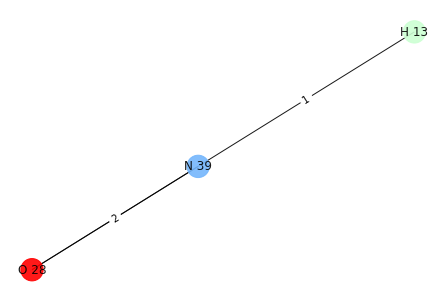

In [14]:
extra_H = [Atom("H", i) for i in range(100,300)]
extra_O = [Atom("O", i) for i in range(100,300)]
extra_C = [Atom("C", i) for i in range(100,300)]
extra_N = [Atom("N", i) for i in range(100,300)]

oidx = 0
hidx = 0
cidx = 0
nidx = 0
changed_graph = {}
################################
for compound in new_final:
    flag = False
    print("Next compound")
    plot_fig(compound)
    for c in aldehyde_ketones[compound]:
        if c[0] in nx.nodes(compound):
            flag = True
            case = "CO"
            break
    if flag == False:
        for cn in cyanides[compound]:
            if cn[0] in nx.nodes(compound):
                flag = True
                case = "CN"
                break
                
    if flag == True and case=="CO":
        print("Aldehyde or Ketone")
        compound = nx.MultiGraph(compound)
        
        compound.remove_edge(c[1], c[0])
        
        new_h = hidx
        compound.add_edge(c[1],extra_H[hidx])
        hidx += 1
        compound.add_edge(c[0],extra_N[nidx])
        for time in range(2):
            compound.add_edge(extra_N[nidx],extra_H[hidx])
            hidx += 1
        nidx += 1
        plot_fig(compound)
        
        compound.remove_edge(c[1], c[0])
        compound.remove_node(c[1])
        compound.remove_node(extra_H[new_h])
        
        compound.add_edge(c[0],extra_C[cidx])
        for time in range(3):
            compound.add_edge(extra_C[cidx],extra_N[nidx])
        plot_fig(compound)
        
        for time in range(3):
            compound.remove_edge(extra_C[cidx],extra_N[nidx])
        compound.remove_node(extra_N[nidx])
        for i in range(2):
            compound.add_edge(extra_C[cidx],extra_O[oidx])
        oidx += 1
        compound.add_edge(extra_C[cidx],extra_O[oidx])
        compound.add_edge(extra_O[oidx],extra_H[hidx])
        hidx += 1
        
        changed_graph[compound] = input_G(compound)
        fix_valencies(compound)
        plot_fig(compound)
        
    elif flag == True and case=="CN":
        print("Cyanide")
        print(cn)
        compound = nx.MultiGraph(compound)
        neigh = compound[cn[0]]
        non_n_neigh = [i for i in neigh if (i._name.split()[0]!="N")]
        
        for time in range(3):
            compound.remove_edge(cn[1], cn[0])
        
        for time in range(2):
            compound.add_edge(cn[0], extra_O[oidx])
        oidx += 1
        
        compound.add_edge(cn[0], extra_O[oidx])
        compound.add_edge(extra_O[oidx], extra_H[hidx])
        hidx += 1
        oidx += 1
        
        compound.remove_node(cn[1])
        changed_graph[compound] = input_G(compound)
        fix_valencies(compound)
        plot_fig(compound, changed_graph[compound])

Code to plot graph of the $\Delta G^{\circ}$ distribution of Glycine and Alanine.

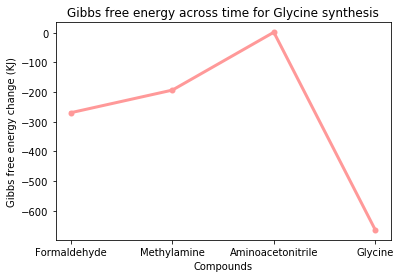

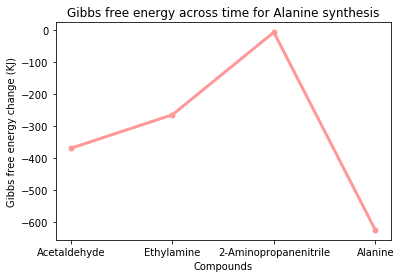

In [15]:
x_axis = ["Formaldehyde", "Methylamine", "Aminoacetonitrile", "Glycine"]
y_axis = [-269.5222798, -193.3923271, 1.575047801, -664.5829247]

plt.figure()
plt.xlabel("Compounds",fontsize = 10)
plt.ylabel('Gibbs free energy change (KJ)',fontsize = 10)
plt.title('Gibbs free energy across time for Glycine synthesis' , fontsize = 12)
plt.plot(x_axis,y_axis, '.-', linewidth=3,  color = '#ff9999', markeredgewidth=3, markerfacecolor='black');

x_axis2 = ["Acetaldehyde", "Ethylamine", "2-Aminopropanenitrile", "Alanine"]
y_axis2 = [-368.2453749, -263.9192457, -6.190248565965583, -623.24864]

plt.figure()
plt.xlabel("Compounds",fontsize = 10)
plt.ylabel('Gibbs free energy change (KJ)',fontsize = 10)
plt.title('Gibbs free energy across time for Alanine synthesis' , fontsize = 12)
plt.plot(x_axis2,y_axis2, '.-', linewidth=3,  color = '#ff9999', markeredgewidth=3, markerfacecolor='black');